In [3]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio # We only need the Audio 'Class' from this package

# Class 12 - DST Lab Spring 2023
## New York University

## State Variable Filter

Used commonly in analog synths: Oberheim OB-X, Yamaha CS-80

Has simultaneous lowpass, highpass and bandpass (and occasionally notch) outputs

Simple relationship between control parameters and filter coefficients. Much easier than canonical 2nd order filter to quickly change cutoff or resonance

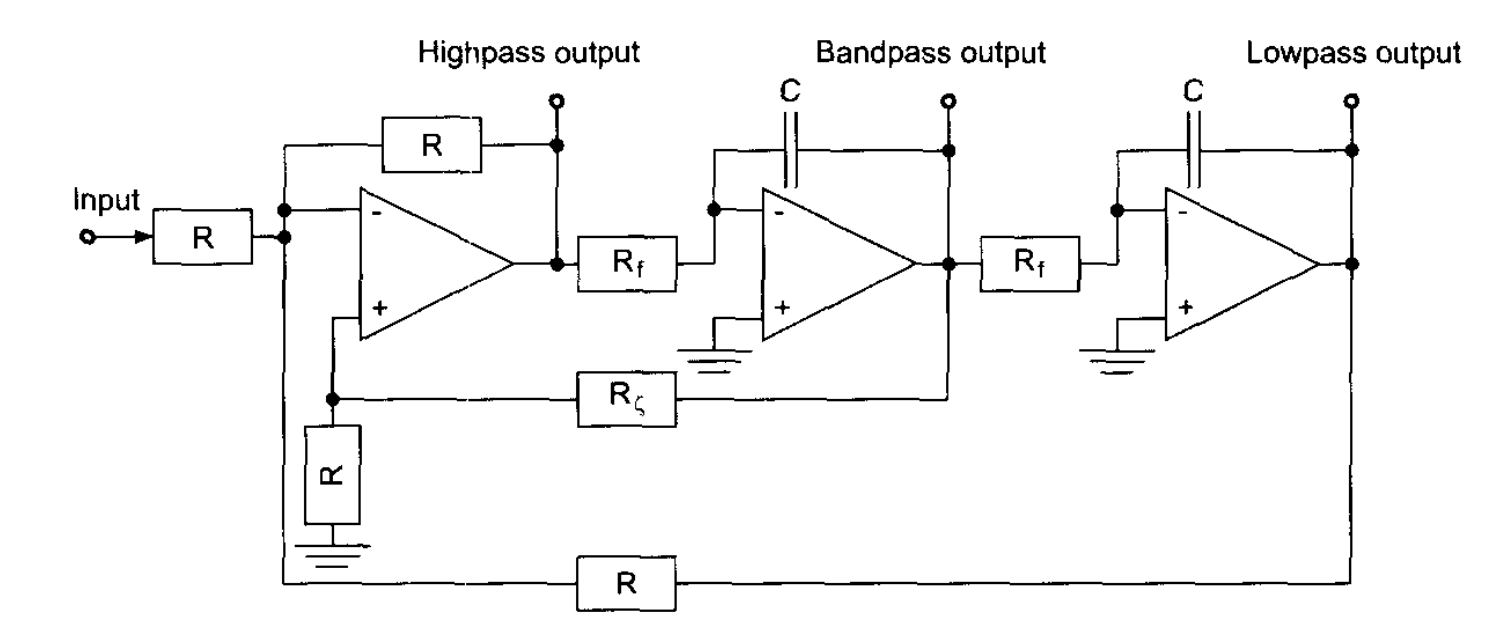

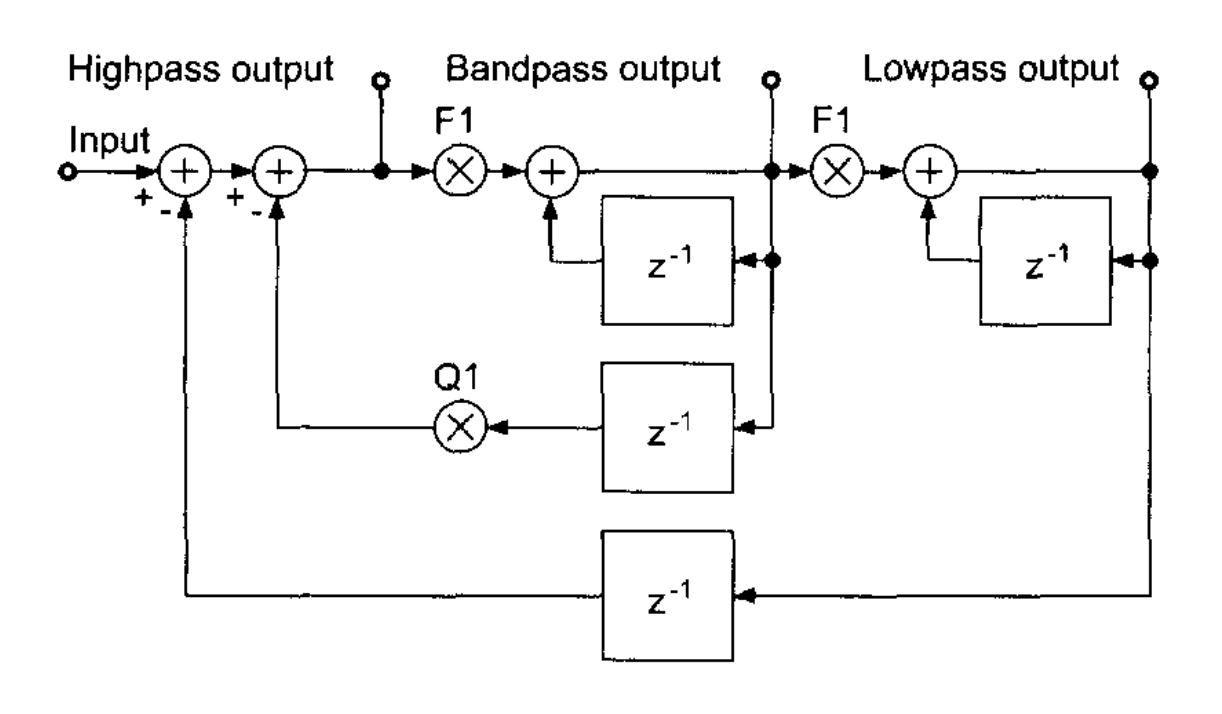

In [ ]:
F = 2 * np.sin(np.pi * cutoff_freq / sample_rate) # cutoff control
Q1 # a number between 0 and 1 given by user. 0 being most resonant 1 being least

low = band * F1 + low
high = x[n] - low[n-1] - band[n-1] * Q
band = high[n]* F1 + band[n-1]

In [14]:
def stateVariable(x, cutoff_freq, sample_rate, Q, filter_type):
    F = 2 * np.sin(np.pi * cutoff_freq / sample_rate)
    
    y = np.zeros(len(x))
    
    low = 0
    high = 0
    band = 0
    notch = 0
    
    for n in range(len(x)):
        low = band * F + low
        high = x[n] - low - Q * band
        band = high * F + band
        notch = low + high
        if (filter_type == 'lowpass'):
            y[n] = low
        elif (filter_type == 'highpass'):
            y[n] = high
        elif (filter_type == 'bandpass'):
            y[n] = band
        elif (filter_type == 'notch'):
            y[n] = notch
        
    return y
    

In [19]:
data, sr = sf.read("sig.wav")

y = stateVariable(data, 100, sr, 0, "notch")

Audio(y, rate = sr)

## Filter Sweep

In [28]:
# resonance between 0 and 1, lower = more resonance
def stateVariableSweep(x, sample_rate, Q, filter_type, sweep):    
    low = 0
    high = 0
    band = 0
    notch = 0
    
    y = np.zeros(len(x))
    
    for n in range(len(x)):
        F = 2 * np.sin(np.pi * sweep[n] / sample_rate)
        low = low + F * band
        high = Q * x[n] - low - Q * band
        band = F * high + band
        notch = high + low
        if (filter_type == 'lowpass'):
            y[n] = low
        elif (filter_type == 'highpass'):
            y[n] = high
        elif (filter_type == 'bandpass'):
            y[n] = band
        elif (filter_type == 'notch'):
            y[n] = notch
    
    return y

In [29]:
data, sr = sf.read("sig.wav")

# my_sweep = np.linspace(10000, 100, len(data))
my_sweep = np.concatenate([np.linspace(100, 10000, len(data)//2), np.linspace(10000, 100, len(data)//2)])


y = stateVariableSweep(data, sr, 0.2, "lowpass", my_sweep)

Audio(y, rate = sr)

In [20]:
help(np.linspace)

Help on function linspace in module numpy:

linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)
    Return evenly spaced numbers over a specified interval.
    
    Returns `num` evenly spaced samples, calculated over the
    interval [`start`, `stop`].
    
    The endpoint of the interval can optionally be excluded.
    
    .. versionchanged:: 1.16.0
        Non-scalar `start` and `stop` are now supported.
    
    .. versionchanged:: 1.20.0
        Values are rounded towards ``-inf`` instead of ``0`` when an
        integer ``dtype`` is specified. The old behavior can
        still be obtained with ``np.linspace(start, stop, num).astype(int)``
    
    Parameters
    ----------
    start : array_like
        The starting value of the sequence.
    stop : array_like
        The end value of the sequence, unless `endpoint` is set to False.
        In that case, the sequence consists of all but the last of ``num + 1``
        evenly spaced samples, so that 

## DELAY STRUCTURES

## FIR (Feedforward) Comb
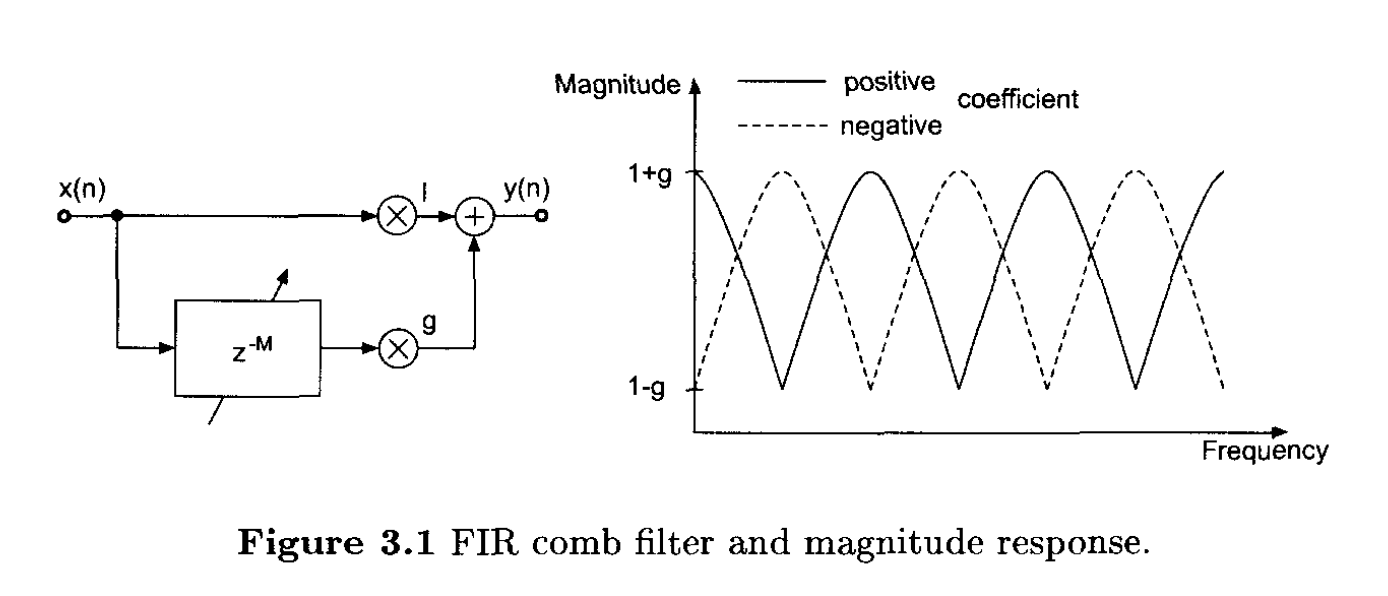

## IIR (Feedback) Comb
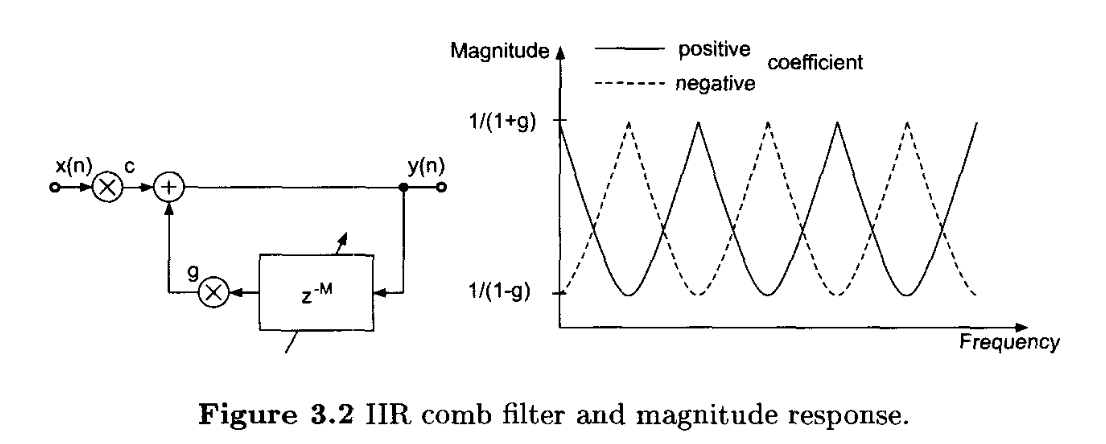

# Allpass (Schroeder allpass comb filter)
Filter has gain of 1 at all frequencies but different phase shifts (delays) at different frequencies
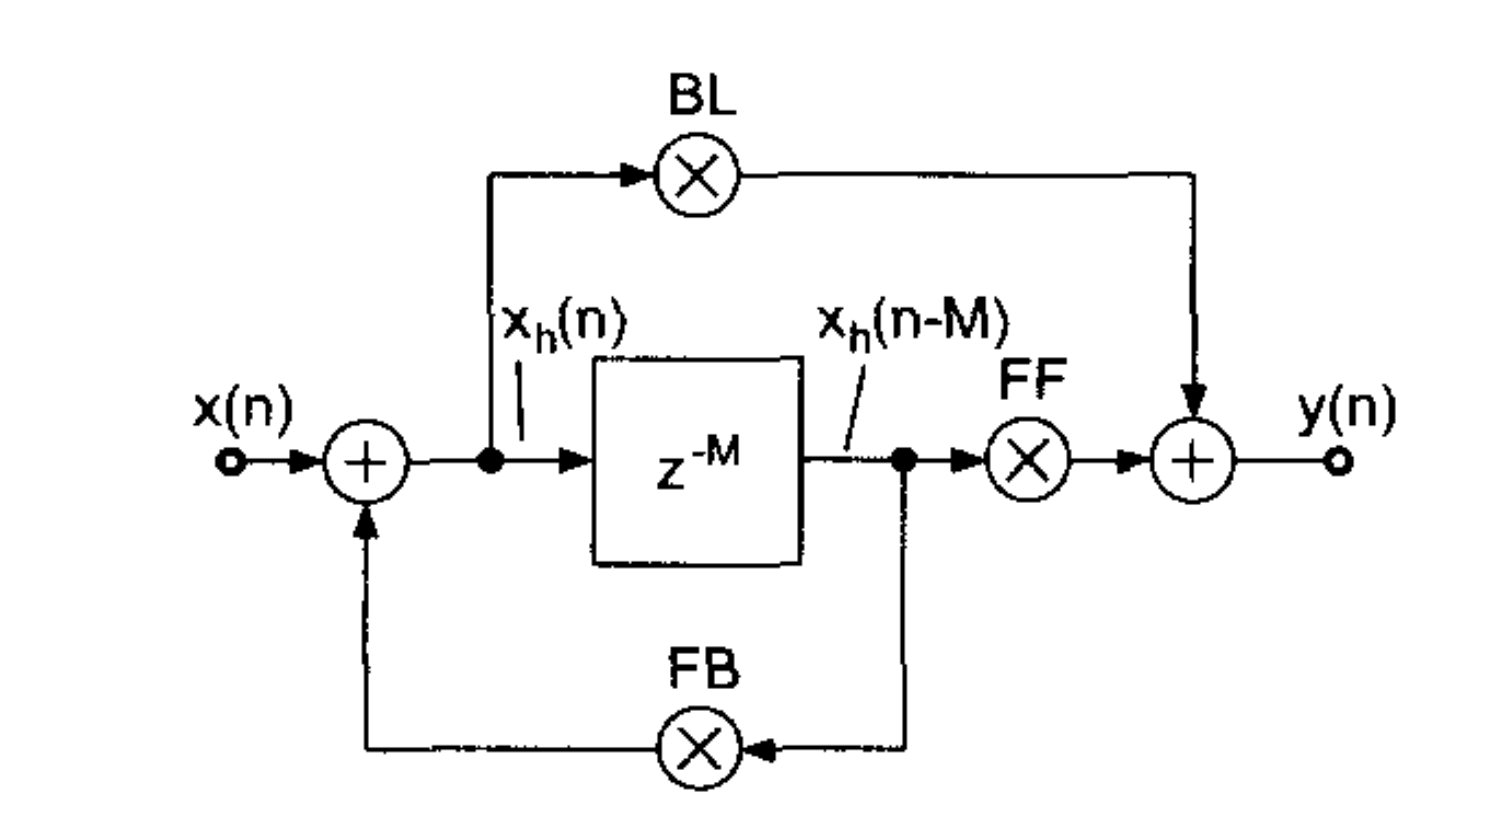

## Allpass filters and delay based effects

## Chorus Effect



In [32]:
def sine_gen(amplitude, frequency, phase, duration, sample_rate):
    t_v = np.arange(0, duration, 1/sample_rate) 
    output = amplitude * np.sin(2 * np.pi * frequency * t_v + phase)
    return output

In [39]:
def chorusSine(x, sample_rate):
    BL = 0.7
    FB = (-0.7)
    
    y = np.zeros(len(x))

    mod = sine_gen(1, 2, 0, len(x)*(1/sample_rate), sample_rate)

    for n in range(len(x)):
        delay = int((mod[n] + 1.3) * 10)
        y[n] = FB * x[n] - FB * y[n-delay] + x[n-delay]
        
    y = y * 0.6 + x
    
    return y

In [40]:
data, sr = sf.read("Guitar.wav")

y = chorusSine(data, sr)

Audio(y, rate = sr)

In [59]:
# lowpassed noise as modulator

def chorusNoise(x, sample_rate):
    BL = 0.7
    FB = (-0.7)
    
    y = np.zeros(len(x))

    low = int(sr * 0.001)
    high = int(sr * 0.03)
    
    mod_unfiltered = np.random.random(len(x))*(1440-48)+48

    mod_filtered = stateVariable(mod_unfiltered, 7, sample_rate, 1, "lowpass")
    plt.plot(mod_unfiltered)
    plt.xlim([0, 100000])
    plt.plot(mod_filtered)
    
    for n in range(len(x)):
        delay = int(mod_filtered[n])
        y[n] = FB * x[n] - FB * y[n-delay] + x[n-delay]
        
    y = y * 0.6 + x
        
    return y

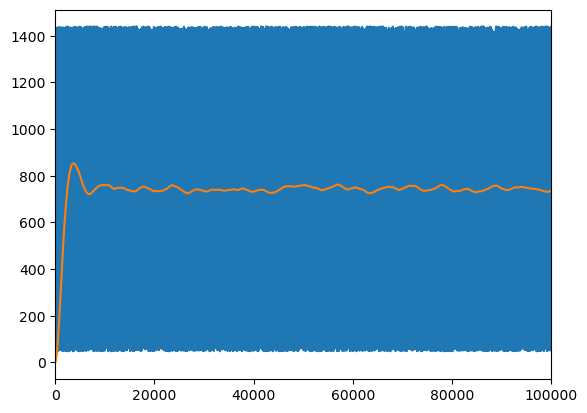

In [60]:
data, sr = sf.read("Guitar.wav")

y = chorusNoise(data, sr)

Audio(y, rate = sr)

In [61]:
def chorusNoiseTwo(x, sample_rate):
    BL = 0.7
    FB = (-0.7)
    
    y = np.zeros(len(x))
    del1 = np.zeros(len(x))
    del2 = np.zeros(len(x))

    low = int(sr * 0.001)
    high = int(sr * 0.03)
    
    mod1 = np.random.random(len(x))*(1440-48)+48
    mod1 = stateVariable(mod1, 7, sample_rate, 1, "lowpass")
    
    mod2 = np.random.random(len(x))*(1440-48)+48
    mod2 = stateVariable(mod2, 7, sample_rate, 1, "lowpass")

    
    for n in range(len(x)):
        delay = int(mod1[n])
        del1[n] = FB * x[n] - FB * del2[n-delay] + x[n-delay]
        
    for n in range(len(x)):
        delay = int(mod2[n])
        del2[n] = FB * x[n] - FB * del2[n-delay] + x[n-delay]
        
    y = x + 0.6*del1 + 0.6*del2
    return y

In [62]:
data, sr = sf.read("Guitar.wav")

y = chorusNoiseTwo(data, sr)

Audio(y, rate = sr)


# Freeverb Algorithm

LBCF = lowpass feedback comb filter (IIR comb with lowpass filter in feedback loop)

AP = Schroeder allpass

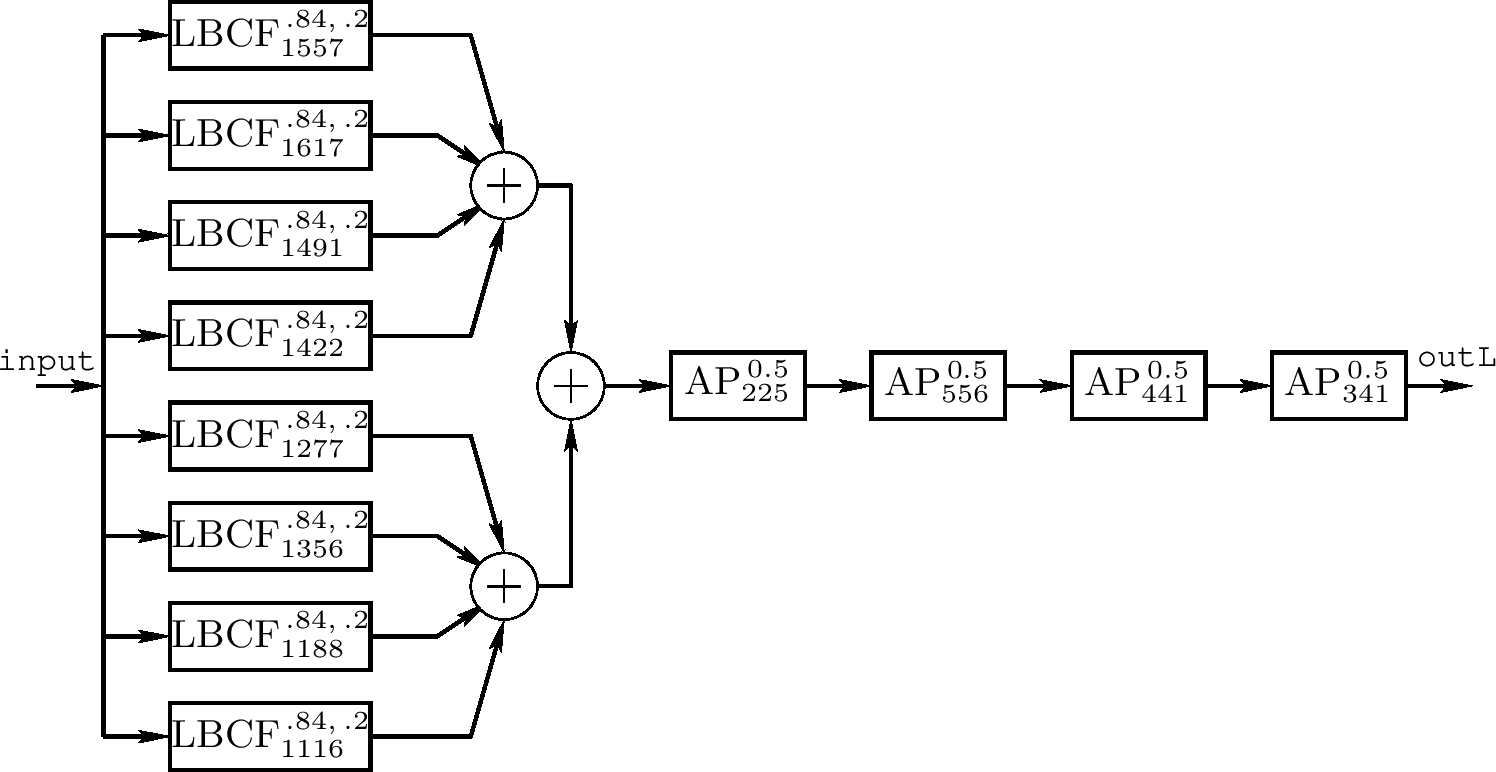

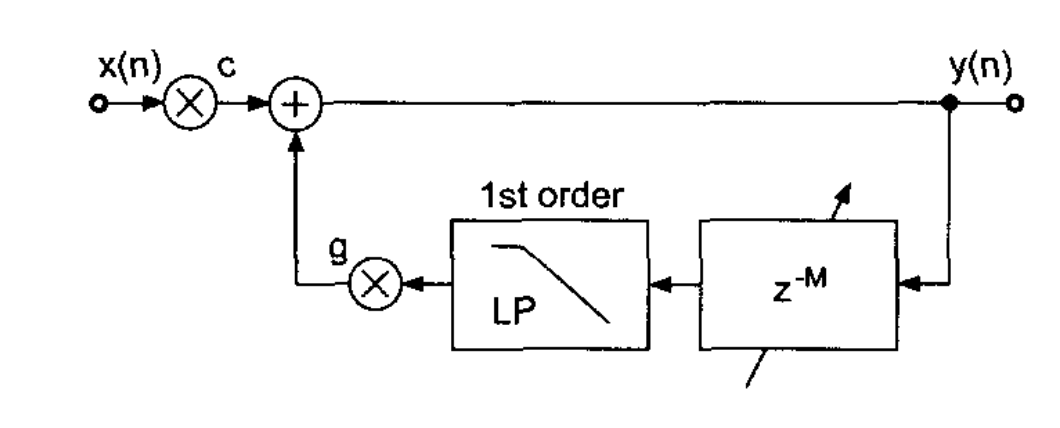